# Deep Learning with PyTorch : Build a Generative Adversarial Network

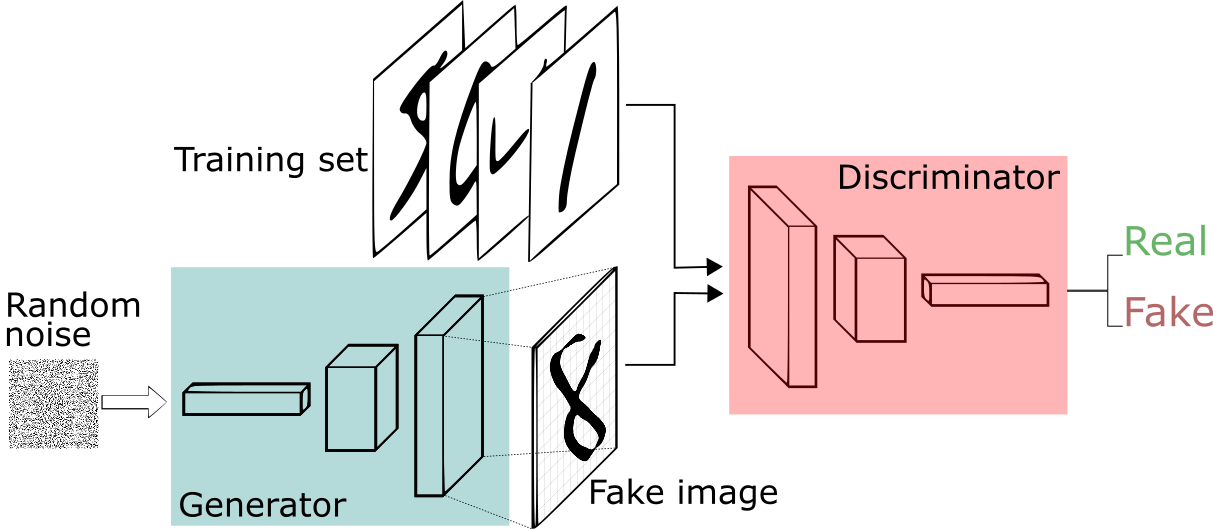

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64

learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

num_epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_aug = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor(),
    # T.Normalize((0.5,), (0.5,))
])

In [ ]:
train_set = datasets.MNIST('MNIST/', download=True, train=True, transform=train_aug)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.35MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



7


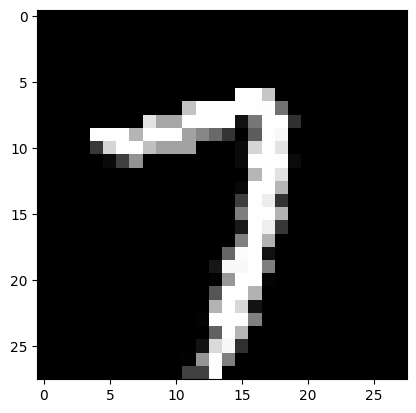

In [ ]:
image, label = train_set[9001]
plt.imshow(image.squeeze(), cmap='gray')
print(label)

# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
data_iter = iter(train_loader)

images, _ = data_iter.next()

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
def show_tensor_images(tensor_img, num_images=16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0) . squeeze())
    plt.show()

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torchsummary import summary # Import the summary function

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class discreaminator(nn.Module):
  def __init__(self):
    super(discreaminator, self).__init__()

    self.block1 = get_disc_block(1, 16, (3,3), 2)
    self.block2 = get_disc_block(16, 32, (5,5), 2)
    self.block3 = get_disc_block(32, 64, (5,5), 2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)

  def forward(self, images):
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [ ]:
D = discreaminator().to(device)

In [ ]:
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if not final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(0.2)
  )

In [ ]:
class generator(nn.Module):
  def __init__(self, noise_dim):
    super(generator, self).__init__()

    self.noise_dim = noise_dim
    self.block1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block2 = get_gen_block(256, 128, (4,4), 1)
    self.block3 = get_gen_block(128, 64, (3,3), 2)
    self.block4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)

    return x4

In [ ]:
G = generator(noise_dim).to(device)

In [ ]:
summary(G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
              Tanh-2            [-1, 256, 3, 3]               0
   ConvTranspose2d-3            [-1, 128, 6, 6]         524,416
              Tanh-4            [-1, 128, 6, 6]               0
   ConvTranspose2d-5           [-1, 64, 13, 13]          73,792
              Tanh-6           [-1, 64, 13, 13]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           1,025
       BatchNorm2d-8            [-1, 1, 28, 28]               2
              ReLU-9            [-1, 1, 28, 28]               0
Total params: 746,947
Trainable params: 746,947
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 2.85
Estimated Total Size (MB): 3.14
-------------------------------------------

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.ones_like(disc_pred))
  return loss

In [ ]:
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))
G_opt = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 1, D_loss0.6042962915607607, G_loss0.7956929593198081


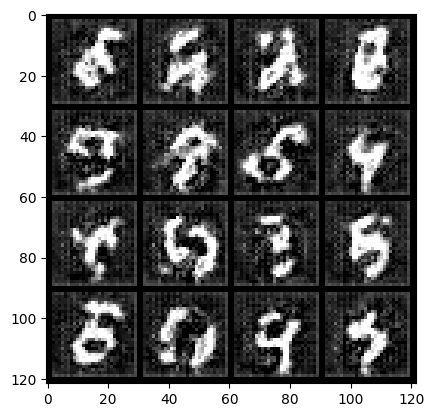

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 2, D_loss0.6114693737741727, G_loss0.8123910091579087


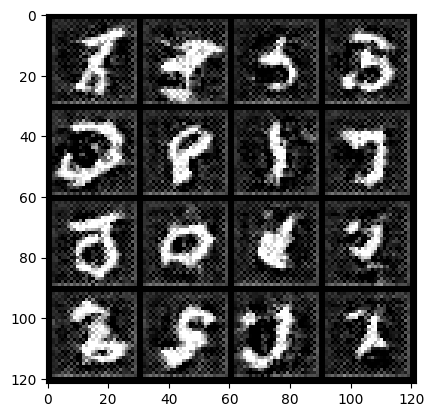

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 3, D_loss0.5743597442153167, G_loss0.8704356274116777


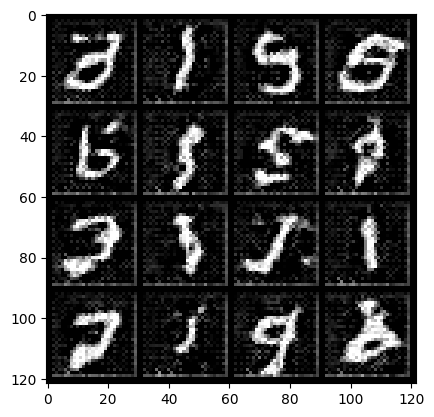

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 4, D_loss0.5394176024236659, G_loss0.947477674052151


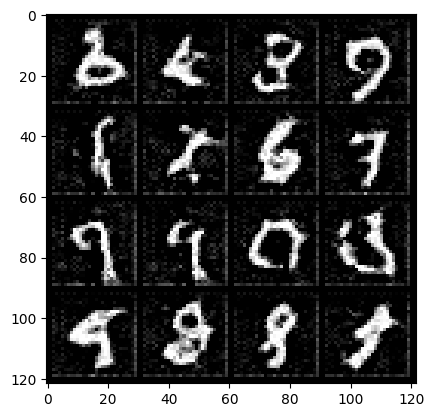

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 5, D_loss0.5047467167951913, G_loss1.0323235752231785


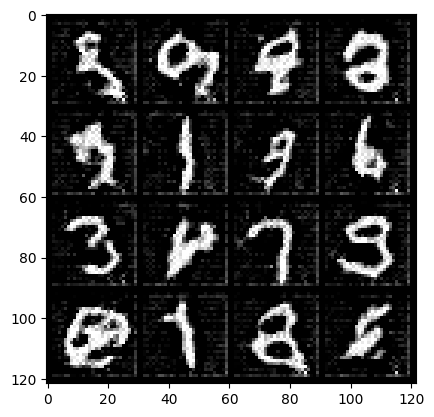

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 6, D_loss0.481108163465569, G_loss1.1040528145934474


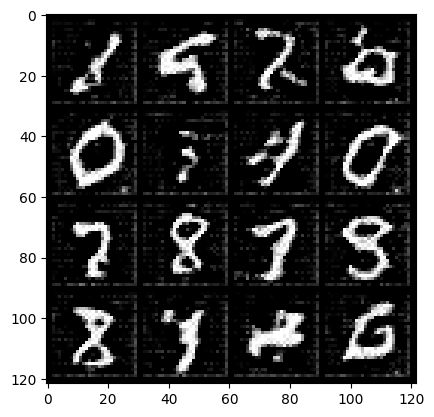

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 7, D_loss0.46461940415378317, G_loss1.1569959234072964


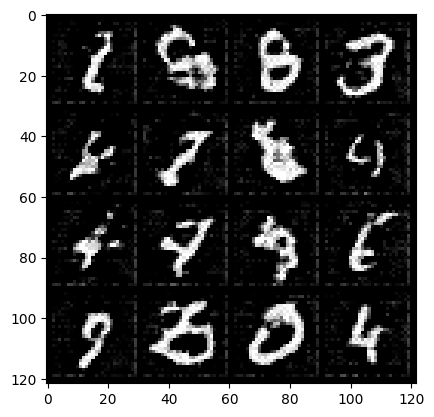

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 8, D_loss0.4540690756809991, G_loss1.1931700370967515


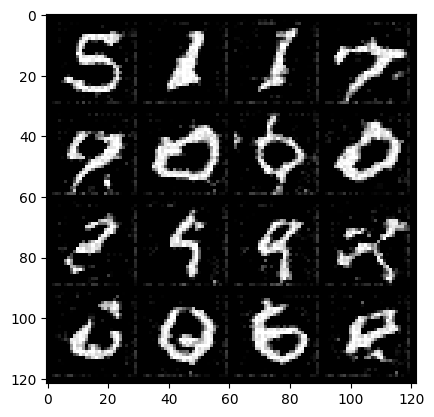

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 9, D_loss0.4522298598594503, G_loss1.2192481727615347


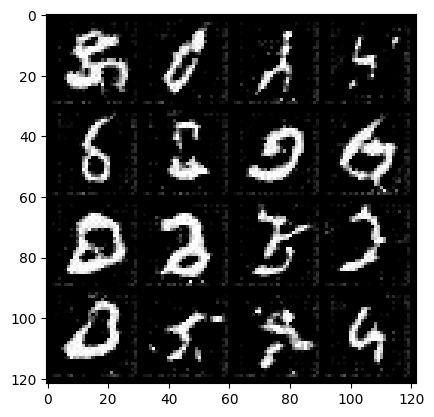

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 10, D_loss0.4482941658639196, G_loss1.2438723962190055


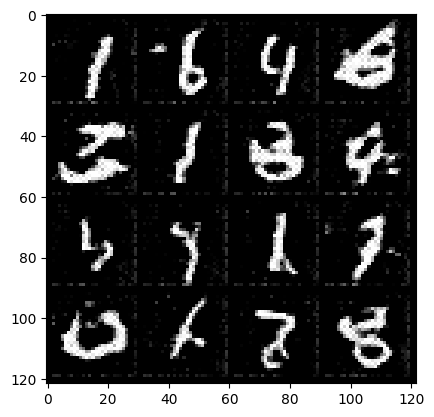

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 11, D_loss0.4458044432500786, G_loss1.2613983932715744


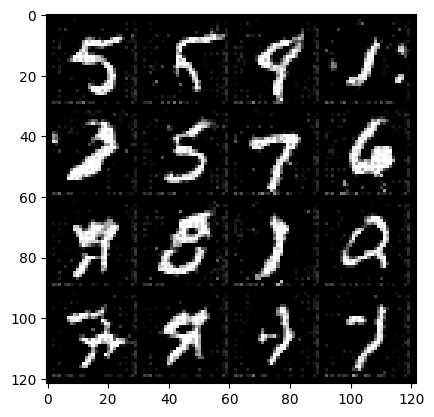

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 12, D_loss0.44436582522605783, G_loss1.2917334466600723


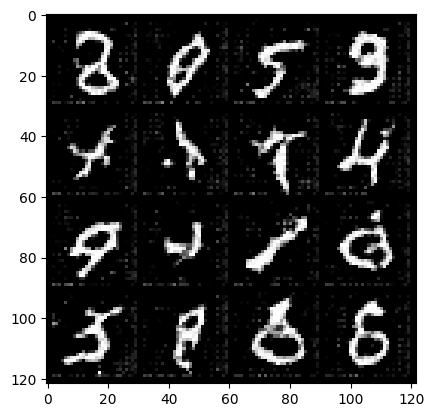

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 13, D_loss0.44134723161583517, G_loss1.2993260171494758


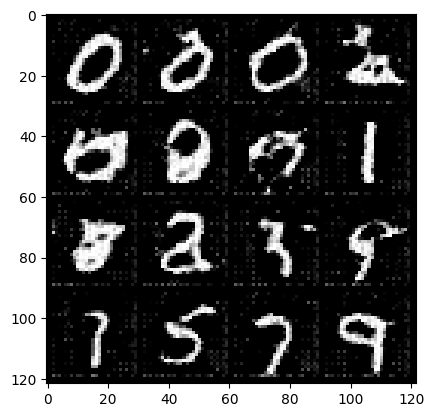

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 14, D_loss0.44385519896997316, G_loss1.3037471666391978


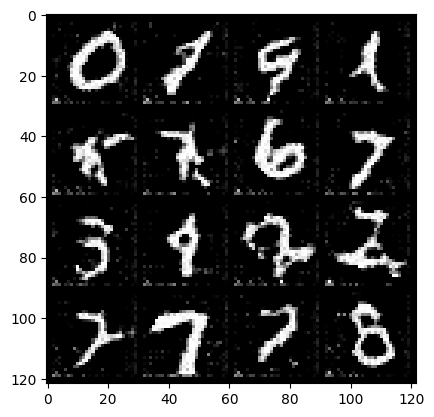

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 15, D_loss0.43955495947205436, G_loss1.3221271372934393


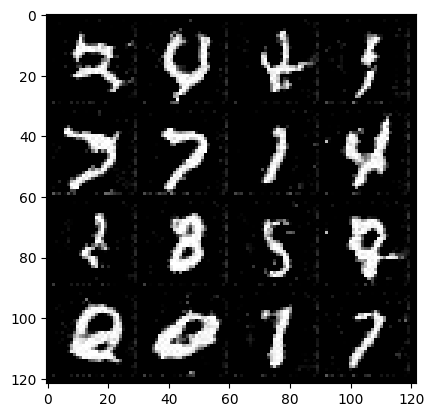

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 16, D_loss0.43881461272107514, G_loss1.3388319757701492


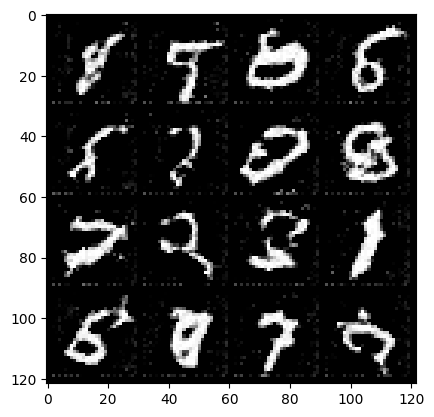

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 17, D_loss0.43860284739465855, G_loss1.3387498841611052


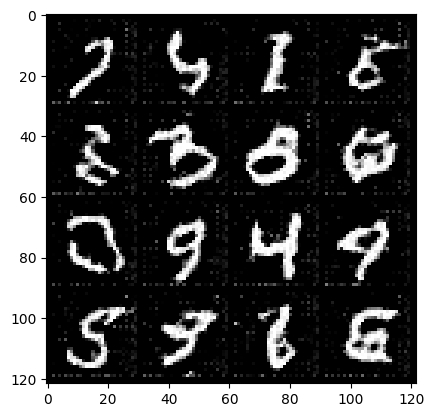

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 18, D_loss0.44080247312212295, G_loss1.349873808147048


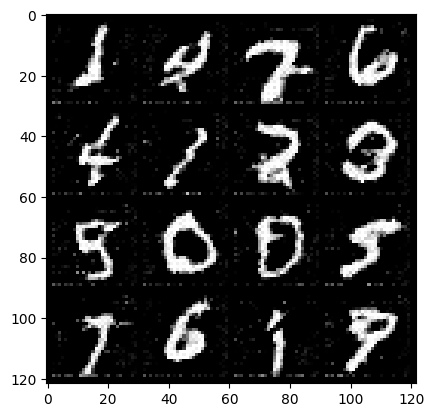

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 19, D_loss0.43324470856804836, G_loss1.3738895006525491


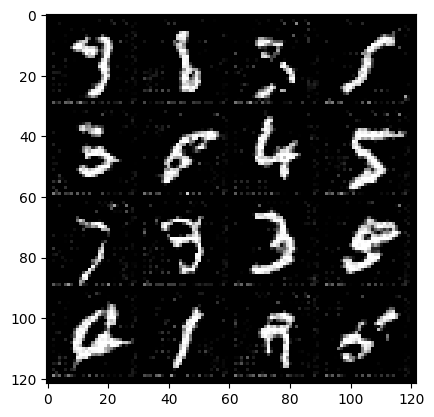

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 20, D_loss0.4376464123919066, G_loss1.3672771072591037


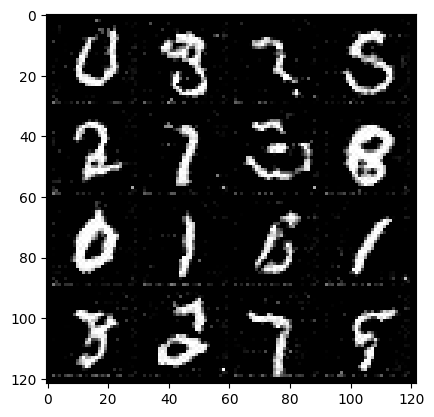

In [ ]:
for i in range(num_epochs):
  total_d_loss = 0
  total_g_loss = 0
  for real_img, _ in tqdm(train_loader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    D_opt.zero_grad()
    fake_images = G(noise)
    D_pred = D(fake_images)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_real_loss + D_fake_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device=device)
    fake_images = G(noise)
    D_pred = D(fake_images)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()


    avg_d_loss = total_d_loss/len(train_loader)
    avg_g_loss = total_g_loss/len(train_loader)


  print(f'epoch {i+1}, D_loss{avg_d_loss}, G_loss{avg_g_loss}')
  show_tensor_images(fake_images)


In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(64, 256, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)